# Задание 1. 
Имеется отрезок длины L.
- Написать алгоритм разбиения отрезка на более мелкие, при этом длина разбивающего отрезка должна увеличиваться от одного конца к другому.
- - Считать, что стартовый разбивающий отрезок задан и имеет длину l, а каждый последующий увеличивается в q раз (q>1). 
- При каких значениях l, q возможно точное разбиение для заданного L?
- - Если точное разбиение невозможно, написать алгоритм минимальной коррекции вводимых параметров l и q и обеспечить точное разбиение.

## Постановка задачи
По сути подобное разбиение отрезка L явзяется ни чем иным, как геометрической последовательностью вида L = l*sum(q^i) где i=0:n, n пренадлежит N.
Отсюда следует, что для того чтобы разбиение было возможно необходимо чтобы было возможным выполнение равенства суммы членов геометрической последовательности:
- L = l*(1-q^n)/(1-q)

Из этого равенства следует что:
- L > 0 (необходимо иначе задача выраждается)
- l > 0 (необходимо иначе равенство не будет выполнени)
- q > 1 (дано по условию задания)

Для решения второй части задания, а именно коррекции параметров l и q формамлизуем данную задачу, как задачу поиска параметров l, q и n таких, что расстояние между точками (l, q) и (l_optimal, q_optimal) былобы минимальным.

## Решение
### Загрузка библиотек

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import time
from numba import jit
from tqdm import tqdm

### Вспомогательные функции
#### Основные функции модели

In [2]:
# Вычисление L
# @jit
def culc_L(l,q,n):
    return l*((1-pow(q,n))/(1-q))

# Вычисление l
# @jit
def culc_l(L,q,n):
    return L*((1-q)/(1-pow(q,n)))

# Вычисление n
# @jit
def culc_n(L,l,q):
    return int(np.log(L*(q-1)+l)/np.log(q))

# Поиск с измельчением сетки
# @jit
def clarifying_search(params_zero, params_amplitude, iterations, mutator, grid_num, weights):
    params_previouse = params_zero[1:]
    for i in range(iterations):
        params_limits = param_border_modifier(params_previouse, params_amplitude)
        tmp_rez = grid_searching (params_zero, params_previouse, params_limits, grid_num, weights)
        if tmp_rez[1][0] < 0:
            break
        params_previouse = tmp_rez[1]
        params_amplitude = (mutator*params_amplitude[0], 
                            mutator*params_amplitude[1], 
                            int(mutator*params_amplitude[2]))
    # Поправка/уточнение решения за счёт l
    l2 = params_previouse[0]*params_zero[0]/culc_L(params_previouse[0],
                                                   params_previouse[1],
                                                   params_previouse[2])
    return (l2, params_previouse[1], params_previouse[2])

# Грубый поиск по сетке
# @jit
def grid_searching (params_zero, params_previouse, params_limits, grid_num , weights):
    # Создание сектки параметров на основании граничных значений и количества
    tmp = grid_maker(params_limits,params_previouse, grid_num)
    (l_grd, q_grd) = tmp[:2]
    (l_steps, q_steps, n_steps) = tmp[2:]
    # Хранилище ЦФ
    best_func = 10E20
    # Хранилище параметров
    best_l_q_n = (-1., -1., -1.)
    for n_grid in n_steps:
        func = (weights[0]*np.abs(culc_L(l_grd,q_grd,n_grid) - params_zero[0]) + # ЦФ сближающая L и L*
                weights[1]*np.abs(params_zero[1] - l_grd) + # ЦФ сближающая l и l*
                weights[2]*np.abs(params_zero[2] - q_grd))  # ЦФ сближающая q и q*
        idx = np.unravel_index(np.argmin(func, axis=None), func.shape)
        if func[idx] < best_func:
            best_l_q_n = (l_steps[idx[1]], q_steps[idx[0]], n_grid)
            best_func = func[idx[0],idx[1]]
    return (best_func,best_l_q_n)

# Расчет новых граничных значений
# @jit
def param_border_modifier(best_param, amp_param):
    # минимальная константа
    eps = 10E-10
    # определение новых граничных значений для l
    l = best_param[0]
    l_amp = amp_param[0]
    l_min = np.max([eps, l - l_amp])
    l_max = l_min + l_amp
    # определение новых граничных значений для q
    q = best_param[1]
    q_amp = amp_param[1]
    q_min = np.max([1 + eps, q - q_amp])
    q_max = q_min + q_amp
    # определение новых граничных значений для n
    n = best_param[2]
    n_amp = amp_param[2]
    n_min = int(np.max([1, n - n_amp]))
    n_max = n_min + int(n_amp)
    # Возвращение списка новых граничных значений
    return ((l_min,l_max), (q_min,q_max), (n_min,n_max))

# Создание сетки
# @jit
def grid_maker(params_limits, params_previouse, grid_num):
    step_treshhold = 10E-5
    # Предельные значения и шаг сетки l
    l_min, l_max = params_limits[0]
    l_step = np.max([step_treshhold,(l_max-l_min)/grid_num])
    # Предельные значения  и шаг сетки q
    q_min, q_max = params_limits[1]
    q_step = np.max([step_treshhold,(q_max-q_min)/grid_num])
    # Предельные значения  и шаг сетки n
    n_min, n_max = params_limits[2]
    n_step = np.max([1,(n_max-n_min)/grid_num]).astype(int)
    # Значения узлов сетки по каждому из параметров l,q,n
    l_steps = np.arange(l_min, l_max, l_step)
    q_steps = np.arange(q_min, q_max, q_step)
    n_steps = np.arange(n_min, n_max, n_step)  
    if params_previouse is None:
        l_steps = np.unique( l_steps )
        q_steps = np.unique( q_steps )
        n_steps = np.unique( n_steps.astype(int) )
    else:
        l_steps = np.sort( np.unique( np.append(l_steps,params_previouse[0]) ) )
        q_steps = np.sort( np.unique( np.append(q_steps,params_previouse[1]) ) )
        n_steps = np.sort( np.unique( np.append(n_steps,params_previouse[2]).astype(int) ) )
    # Сама сетка для l и q
    l_grid, q_grid = np.meshgrid(l_steps, q_steps, sparse=True)
    return l_grid, q_grid, l_steps, q_steps, n_steps

#### Функции для поиска оптимальных гиперпараметров модели

In [3]:
# Генерация тестовых данных
# @jit
def make_test_data():
    eps = 10E-10
    params_limits = param_border_modifier((1,2,1), (10E4,10E3,50))
    tmp = grid_maker(params_limits, None, 10)
    l_steps = tmp[2]
    q_steps = tmp[3]
    n_steps = tmp[4]
    test_data=[]
    l_stp=-1
    q_stp=-1
    n_stp=-1
    for l_val in l_steps:
        if l_stp < 0:
            l_stp = l_steps[1]-l_steps[0]
        for q_val in q_steps:
            if q_stp < 0:
                q_stp = q_steps[1]-q_steps[0]
            for n_val in n_steps:
                if n_stp < 0:
                    n_stp = n_steps[1]-n_steps[0]
                L = culc_L(l_val,q_val,n_val)
                if L<float("inf"):
                    l_noisy = np.max([eps, int(l_val + l_stp*(random.random()-0.5))])
                    q_noisy = np.max([1+eps, int(q_val + q_stp*(random.random()-0.5))])
                    abs_log_err = np.abs(np.log10(L)-np.log10(culc_L(l_noisy,q_noisy,n_val)))
                    if 0.5 < abs_log_err < 2 :
                        test_data.append((L,l_val,q_val,n_val,l_noisy,q_noisy))
    test_data = np.array(test_data)
    return test_data

# Оценивание конкретной модели на качество на основании набора данных
# @jit
def scoring_custom_model2(test_data, optim_params):
    iterations = optim_params[0] # = 10
    mutator = optim_params[1] # = 0.9
    grid_num = optim_params[2] # = 5
    par_amp_l = optim_params[3][0] # = (100., 20., 10)
    par_amp_q = optim_params[3][1]
    par_amp_n = optim_params[3][2]
    w_L = optim_params[4][0] # = [0.3,0.3,0.3]
    w_l = optim_params[4][1]
    w_q = optim_params[4][2]
    return scoring_custom_model(
        test_data, iterations, mutator, grid_num,
        par_amp_l, par_amp_q, par_amp_n, w_L, w_l, w_q)

# @jit
def scoring_custom_model(
    test_data, iterations, mutator, grid_num, 
    par_amp_l, par_amp_q, par_amp_n, w_L, w_l, w_q):
    params_amplitude = (par_amp_l, par_amp_q, par_amp_n)
    w = (w_L, w_l, w_q)
    errors = np.zeros([test_data.shape[0], 4])
    time_0 = time.time()
    for i in range (test_data.shape[0]):
        t_d = test_data[i,:]
        L = t_d[0]
        l = t_d[4]
        q = t_d[5]
        n = int(np.log(L*(q-1)+l)/np.log(q))
        params_zero = (L, l, q, n)
        rez = clarifying_search(params_zero, params_amplitude,
                                iterations, mutator, grid_num, w)
        errors[i,0] = np.abs(np.log(culc_L(rez[0],rez[1],rez[2])) - np.log(L))
        errors[i,1] = np.abs(t_d[1]-rez[0])
        errors[i,2] = np.abs(t_d[2]-rez[1])
        errors[i,3] = np.abs(t_d[3]-rez[2])
    time_elapsed = time.time()-time_0
    rez0 = [time_elapsed]
    rez0.extend(np.mean(errors,axis=0).tolist())
    return rez0

# # Поиск оптимальных весов
# test_data = make_test_data()
# print(test_data.shape[0])
# iterations = 40 # < 40 optimal
# mutator = 0.2 # <= 0.2 optimal
# grid_num = 21 #21 < 35 optimal
# params_amplitude = (15., 10., 5) # <= (50, 10, 5) optimal
# weights = (0.74, 0.13, 0.13) # weights_L > 0.6 optimal
# rezults_list = []
# params_list = []
# time1 = time.time()
# goal_list = []
# for amp_n in tqdm(params_amplitude_n):
#     for amp_l in params_amplitude_l:
#         for amp_q in params_amplitude_q:
#             optim_params = (
#                 iterations, # iterations
#                 mutator, # mutator
#                 grid_num, # grid_num
#                 (amp_l, amp_q, amp_n), # params_amplitude
#                 weights
#             )
#             params_list.append((amp_n, amp_l, amp_q))
#             tmp = scoring_custom_model2(test_data, optim_params)
#             rezults_list.append(tmp)
#             goal_list.append(np.log(tmp[0]*tmp[2]*tmp[3]))

# rezults_list = np.array(rezults_list)
# params_list = np.array(params_list)
# goal_list = np.array(goal_list)
# idx = np.where(params_list[:,2]<=10)
# idx2 = np.where( params_list[idx[0],1]<=50)
# idx = idx[0][idx2]
# i = 0
# y = rezults_list[idx,i]
# # y = rezults_list[idx,0]*rezults_list[idx,3]
# plt.scatter(params_list[idx,0],y)
# plt.show()
# plt.scatter(params_list[idx,1],y)
# plt.show()
# plt.scatter(params_list[idx,2],y)
# plt.show()

### Входные данные

In [4]:
# Даны
L = 250.
l = 3.2
q = 5.1
print('L: ' + str(L) + '\n' + 'l: ' + str(l) + '\n' + 'q: ' + str(q))

L: 250.0
l: 3.2
q: 5.1


### Коррекция l и q

In [5]:
# Определение оптимальных l и q, а так же нахождение n
n = culc_n(L,l,q)
params_zero = (L, l, q, n)
params_amplitude = (45., 10., 5)
iterations = 30
mutator = 0.15
grid_num = 30
weights = (0.74, 0.13, 0.13)
(l_optim, q_optim, n_optim) =clarifying_search(params_zero, params_amplitude, iterations, mutator, grid_num, weights)
print('l_optim: ' + str(np.round(l_optim,4)) + '\n' +
       'q_optim: ' + str(np.round(q_optim,4)) + '\n' +
        'n_optim: ' + str(n_optim))

l_optim: 3.8294
q_optim: 7.5333
n_optim: 3


### Разбиение на отрезки

In [6]:
print('Пусть отрезок L начинается от 0 и находится в положительной области и имеет координаты:')
print(np.round(np.array((0,L)),2))
segments_list = []
previous_segment_end = 0.
for n_iter in range(n_optim):
    segmet_end = previous_segment_end + l_optim*q_optim**n_iter
    segments_list.append((previous_segment_end, segmet_end))
    previous_segment_end = segmet_end
segments = np.array(segments_list)
print('Тогда, список координат отрезков разбиения следующий:')
print(np.round(segments,2))


Пусть отрезок L начинается от 0 и находится в положительной области и имеет координаты:
[  0. 250.]
Тогда, список координат отрезков разбиения следующий:
[[  0.     3.83]
 [  3.83  32.68]
 [ 32.68 250.  ]]


# Задание 2.
Имеется набор 𝑁 векторов из двумерного пространства. Известно, что x, y координаты M векторов равномерно распределены на [0,1], а концы других 𝑁−𝑀 векторов образуют в пространстве ℝ2 кривую вида 𝑥2/𝑎2 + 𝑦2/𝑏2 + 𝑛 = 1, где n - нормальный шум с нулевым средним и дисперсией ≪𝑎,𝑏. Метки классов выставлены случайно неверно в 5% случаев для каждого класса.
- Необходимо разработать линейно-регрессионную модель, определяющая, к какому из двух классов принадлежит каждая точка из представленного множества.

Замечание:
- Алгоритм не должен опираться на априорные знания о виде описанной выше кривой.

## Постановка задачи
Данную задачу можно переформулировать иначе:
В думерном пространстве дано N точек пренадлежащих 2-м классм.
- Первому классу пренадлежат точки пренадлежащие квадрату в верхней правой четверти со стороной 1  и координатами вершин (0,0), (0,1), (1,1) и (1,0).
- Второму классу пренадлежат точки лежащие на кольце в виде элепса ( где центр кольца это элипс с длиной a и шириной b) с шириной кольца 6*n (где n имеет нормальное распределение с мат.ожиданием 0 и дисперсией ≪ min(𝑎,𝑏)).

Так же известно что метки классов выставлены с ошибкой в 5%.

В качестве ЦФ возьмем среднее f1-меру между оценками для 0-го и 1-го класса.

Необходимо:
- Найти оптимальную прямую и минимальное количество точек переключения m, такие что ошибка на проверочной выборке была бы минимальной.

## Решение
Вместо того чтобы искать плоскость которая обеспечит нам лучшее разбиение, будем искать матрицу поворота и значение X_separation в повернутой системе координат, которые обеспечат наилучшее разбиение на классы.

### С чего начать поиск матрицы поворота?
Для того чтобы вычислить первое приближение оптимальной матрицы поворота:
- рассчитаем центры 0-го и 1-го класса (как среднее по каждой координате по всем точкам каждого из классов)
- найдем уравнение прямой проходящей через эти центры
- и из параметра наклона прямой вычислим угол для матрицы поворота

### Определение X_separation
Для определения лучшего значения X_separation для разделения на классы используем равномерное разбиение области возможных значений X_separation с итеративным измельчением в области роста ЦФ.

### Поиск оптимальной матрицы поворота
Для определения оптимальной матрицы поворота используе схожий подход что и для поиска лучшего X_separation, а именно:
- от первого приближения матрицы поворота отступим в каждую сторону на -pi/4 и +pi/4 обозначим это как область возможных значений для угла матрицы поворота
- далее с равномерным разбиением области возможных значений угла поворота с итеративным измельчением в области роста ЦФ определим лучший угол для матрицы поворота

### Загрузка библиотек

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import gmean
from scipy.stats.mstats import hmean
import math
from tqdm import tqdm

### Вспомогательные функции
#### Функции для построения исходных данных

In [8]:
def make_test_data(N_num= 1000, a= 4, b= 2, proportion= 0.5 , error_proportion= 0.05, n_var = None):
    M_num = int(N_num*proportion)
    M_num_prop_x = int(b/(a+b)*M_num)
    M_num_prop_y = M_num - M_num_prop_x
    M = np.zeros([M_num,3])
    if n_var == None:
        n_var = np.min([a,b])/9
    n = np.random.normal(0, n_var, M_num)
    rand_sign = 2*(np.random.uniform(0, 1, [M_num,1])>0.5).astype(int)-1 
    rand_x = np.random.uniform(-a, a, M_num_prop_x)
    M[:M_num_prop_x,:2] = rand_sign[:M_num_prop_x]*np.array([rand_x, ellipseM_y(rand_x,a,b,n[:M_num_prop_x])]).T
    rand_y = np.random.uniform(-b, b, M_num_prop_y)
    M[M_num_prop_x:,:2] = rand_sign[M_num_prop_x:]*np.array([ellipseM_x(rand_y,a,b,n[M_num_prop_x:]), rand_y]).T
    M[:,2] = 1
    M[np.random.choice(M_num, int(M_num*error_proportion)), 2] = 0
    K_num = N_num - M_num
    K = np.concatenate((np.random.uniform(0,1,[K_num,2]), np.zeros([K_num,1])), axis=1)    
    K[np.random.choice(K_num, int(K_num*error_proportion)), 2] = 1
    return np.concatenate((M, K), axis=0)

def ellipseM_x(y,a,b,n):
    return a*(np.max([y*0, 1 - n - y**2/b**2], axis=0))**0.5

def ellipseM_y(x,a,b,n):
    return b*(np.max([x*0, 1 - n - x**2/a**2], axis=0))**0.5

#### Функции классификатора

In [9]:
# Поиск оптимального угла матрицы поворота
def find_best_slope(dat_train, dat_test, dat_val,iterations_slope,n_steps_slope,iterations_sep,n_steps_sep):
    X_train = dat_train[0]
    y_train = dat_train[1]
    point0 = np.mean(X_train[y_train==0,:],axis=0)
    point1 = np.mean(X_train[y_train==1,:],axis=0)
    a = func_par(point0, point1)
    theta = math.atan(a[0])
    best_rez = np.zeros(7)
    limits = (theta-math.pi/4, theta+math.pi/4)
    step = 0
    for iter in tqdm(range(iterations_slope)):
        rez=[]
        if iter>0:
            limits = (best_rez[6]-step, best_rez[6]+step)
        step = (limits[1]- limits[0])/n_steps_slope
        for t in np.arange(limits[0],step+limits[1],step):
            tmp = find_best_separation(dat_train, dat_test, dat_val,math.tan(t),iterations_sep,n_steps_sep)
            tmp.append(math.tan(t))
            rez.append(tmp)
        rez = np.array(rez)
        idx = np.argmax(rez[:,2])
        if best_rez[2]<rez[idx,2]:
            best_rez = rez[idx,:]
            scores = best_rez[:3]
            optimal_params = best_rez[3:]
    return scores, optimal_params

# Поиск оптимального X_separation
def find_best_separation(dat_train, dat_test, dat_val,a0,iterations,n_steps):
    X_train = dat_train[0]
    y_train = dat_train[1]
    X_test =  dat_test[0]
    y_test =  dat_test[1]
    X_val =   dat_val[0]
    y_val =   dat_val[1]
    
    Xr_train, Xr_shift= rotation_and_shift_y0(a0,X_train,y_train)
    Xr_test, _ = rotation_and_shift_Xshift(a0,X_test,Xr_shift)
    Xr_val, _ = rotation_and_shift_Xshift(a0,X_val,Xr_shift)
    best_rez = np.zeros(6)
    best_rez[4:] = Xr_shift
    limits = (np.max([np.min(Xr_train[y_train==0,0]),np.min(Xr_train[y_train==1,0])]),
              np.min([np.max(Xr_train[y_train==0,0]),np.max(Xr_train[y_train==1,0])]))
    step = 0
    for iter in range(iterations):
        rez=[]
        if iter>0:
            limits = (best_rez[3]-step, best_rez[3]+step)
        step = (limits[1]- limits[0])/n_steps
        for shift in np.arange(limits[0],step+limits[1],step):
            y_pred_train = np.zeros(y_train.shape)
            y_pred_train[(Xr_train[:,0]+shift)<=0] = 1
            y_pred_test = np.zeros(y_test.shape)
            y_pred_test[(Xr_test[:,0]+shift)<=0] = 1
            y_pred_val = np.zeros(y_val.shape)
            y_pred_val[(Xr_val[:,0]+shift)<=0] = 1
            rez.append(
                (f1_fixed(y_train,y_pred_train),
                 f1_fixed(y_test,y_pred_test),
                 f1_fixed(y_val,y_pred_val),shift))
        rez = np.array(rez)
        idx = np.argmax(rez[:,0])
        if best_rez[1]<rez[idx,1]:
            best_rez[:4] = rez[idx,:]
    return best_rez.tolist()

# Поворот
def rotation(a0,X0):
    theta= math.atan(a0)
    mx = np.array(((math.cos(theta), math.sin(theta)),(-1*math.sin(theta), math.cos(theta))))
    return mx.dot(X0.T).T

# Поворот со смещением (вычисляемым как среднее между центрами классов)
def rotation_and_shift_y0(a0, X0, y0):
    X02 = rotation(a0,X0)
    X_shift= np.mean((np.mean(X02[y0==0,:],axis=0),np.mean(X02[y0==1,:],axis=0)),axis=0)
    return X02 - X_shift, X_shift

# Поворот со смещением (которое дано)
def rotation_and_shift_Xshift(a0, X0, X_shift):
    X02 = rotation(a0,X0)
    return X02 - X_shift, X_shift

# Поворот со смещением (вычисляемым как среднее по всем точкам)
def rotation_and_shift(a0, X0):
    X02 = rotation(a0,X0)
    X_shift= np.mean(X02,axis=0)
    return X02 - X_shift, X_shift

# Определение параметров прямой проходящей через две данные точки
def func_par(X0, X1):
    a = (X0[1]-X1[1])/(X0[0]-X1[0])
    return (a, X0[1]-a*X0[0])

# Предсказание класса(на основании параметров оптимизации) на предоставленных данных X
def calc_pred(X, optimal_params):
    optim_shift, optim_Xr_shift1, optim_Xr_shift2, optim_slope = optimal_params
    Xr,_ = rotation_and_shift_Xshift(optim_slope,X,(optim_Xr_shift1,optim_Xr_shift2))
    y_pred = np.zeros(X.shape[0])
    y_pred[(Xr[:,0]+optim_shift)<=0] = 1
    return y_pred

# Расчет средней f1-меры (как среднего из оценок f1-меры для каждого из классов)
def f1_fixed(y_real,y_pred):
    tp = np.max([10e-10,np.sum((y_pred[y_real==0]==0).astype(int))])
    fn = np.max([10e-10,np.sum((y_pred[y_real==0]==1).astype(int))])
    fp = np.max([10e-10,np.sum((y_pred[y_real==1]==0).astype(int))])
    tn = np.max([10e-10,np.sum((y_pred[y_real==1]==1).astype(int))])
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    pre2 = tn/(tn+fp)
    rec2 = tn/(tn+fn)
    f1 = 2*pre*rec/(pre+rec)
    f1_2 = 2*pre2*rec2/(pre2+rec2)
    return (f1+f1_2)/2

### Входные данные

In [10]:
# Генерация исходных данных
N = make_test_data(
                    2000, # - общее количество точек
                    4,    # - размер элепса по x
                    2,    # - размер элепса по y
                    0.5,  # - соотношение между классами пренадлежащими квадрату и элепсу
                    0.05, # - доля ошибочных отметок класса
                    0.1 # - разброс относительно среднего элепса
                )
# Разделение данных
X = N[:,:2] # - координаты
y = N[:,2]  # - метки классов

### Разделение на проверочную и обучающую выборки
Здесь произведем разделение на проверочную и обучающую выборки.

Однако обучающую выборку так же разобьем на несколько независимых частей, так чтобы выборы которые приходится предпренимать в процессе оптимизации базировались на не связных друг с другом выборках.

In [11]:
# ключ случайного генератора
r_state = 71

# Выделение валидационной выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=r_state)

# Разбиение обучающих данных на 3 независимые части
X_tr1, X_tr0, y_tr1, y_tr0 = train_test_split(X_train, y_train, stratify=y_train, test_size=1/3, random_state=r_state)
X_tr2, X_tr3, y_tr2, y_tr3 = train_test_split(X_tr0, y_tr0, stratify=y_tr0, test_size=0.5, random_state=r_state)
dat_tr1 = (X_tr1,y_tr1)
dat_tr2 = (X_tr2,y_tr2)
dat_tr3 = (X_tr3,y_tr3)

### Обучение классификатора

In [12]:
(scores, optimal_params) \
                 = find_best_slope(
                                    (X_tr1,y_tr1), # - данные для поиска первого приближения
                                    (X_tr2,y_tr2), # - данные для определения оптимального X_separation
                                    (X_tr3,y_tr3), # - данные для определения оптимального угла поворота
                                    10, # - количество итераций измельчения для поиска угла поворота
                                    10, # - количество равных шагов разбиения при поиске угла поворота
                                    10, # - количество итераций измельчения для поиска X_separation
                                    10  # - количество равных шагов разбиения при поиске X_separation
                                  )

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


### Проверка качества полученной модели
#### Качество рассматриваемого классификатора

f1-score (validation data): 0.7202


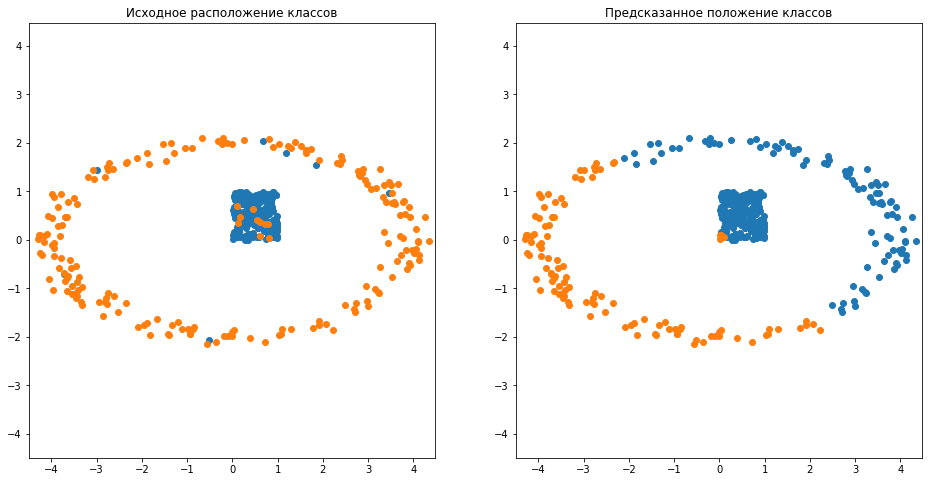

In [13]:
y_pred = calc_pred(X_val, optimal_params)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_pred==0,0],X_val[y_pred==0,1])
ax2.scatter(X_val[y_pred==1,0],X_val[y_pred==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_pred),4)))

#### Сравнение с другими классификаторами

In [14]:
C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
model2 = svm.LinearSVC(C=C, max_iter=10000).fit(X_train, y_train)
model3 = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train)
model4 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C).fit(X_train, y_train)

f1-score (validation data): 0.6659


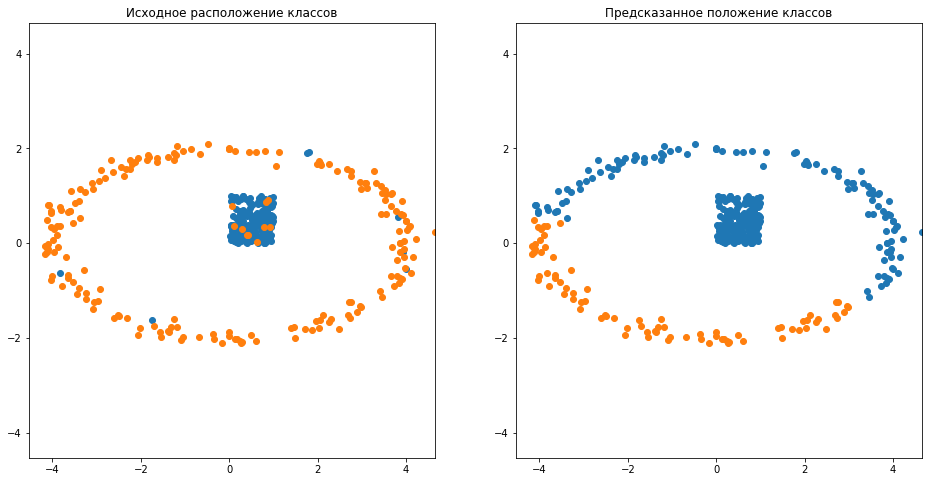

In [10]:
y_p_m1 = model1.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m1==0,0],X_val[y_p_m1==0,1])
ax2.scatter(X_val[y_p_m1==1,0],X_val[y_p_m1==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m1),4)))

f1-score (validation data): 0.6468


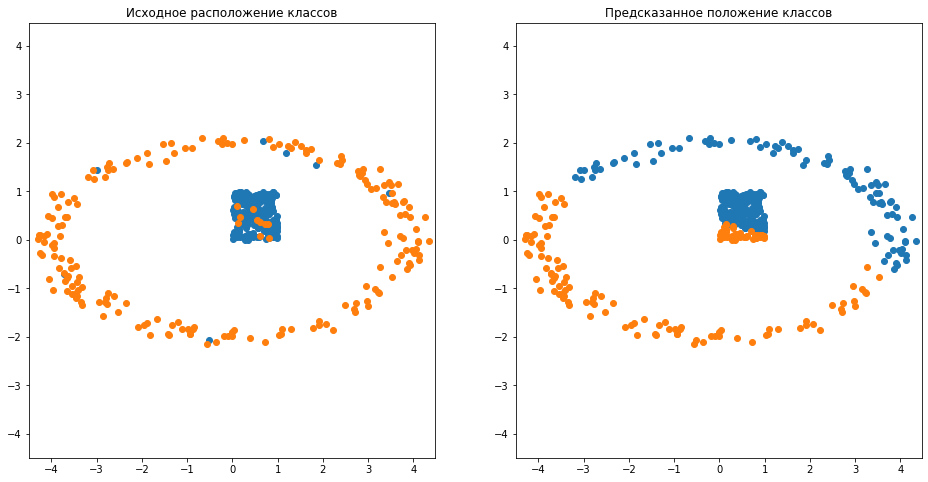

In [15]:
y_p_m2 = model2.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m2==0,0],X_val[y_p_m2==0,1])
ax2.scatter(X_val[y_p_m2==1,0],X_val[y_p_m2==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m2),4)))

f1-score (validation data): 0.9575


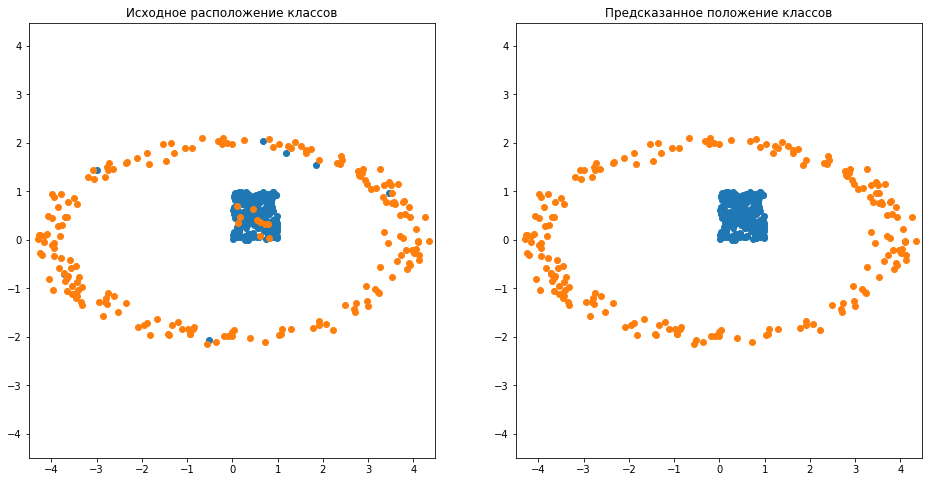

In [16]:
y_p_m3 = model3.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m3==0,0],X_val[y_p_m3==0,1])
ax2.scatter(X_val[y_p_m3==1,0],X_val[y_p_m3==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m3),4)))

f1-score (validation data): 0.6468


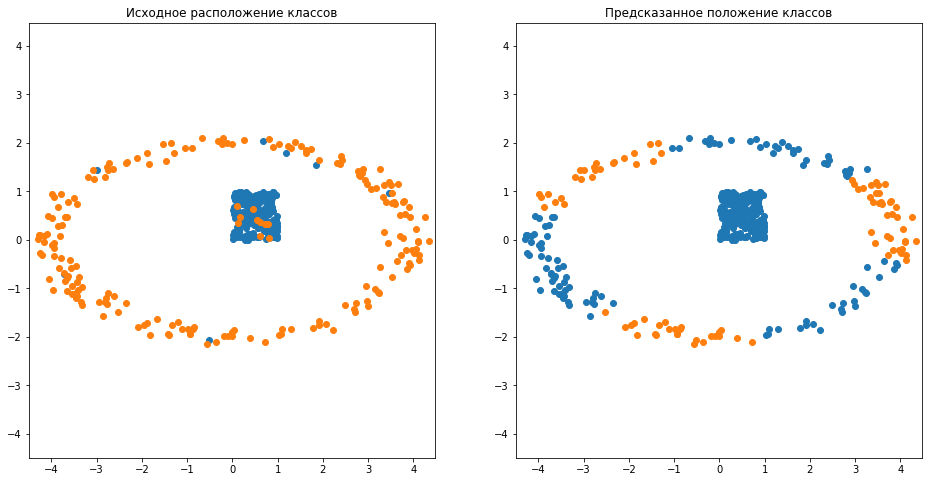

In [17]:
y_p_m4 = model4.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m4==0,0],X_val[y_p_m4==0,1])
ax2.scatter(X_val[y_p_m4==1,0],X_val[y_p_m4==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m2),4)))

#### Результат сравнения
Как можно видеть, предложенный метод классификации уступает по качеству только методу опорных векоров (в его нелинейной версии).

## Задание 4.
На сайте Мирового Центра Данных по Солнечно-Земной Физике (http://www.wdcb.ru/stp/solar/sunspots.ru.html) имеется датасет с ежедневными измерениями числа солнечных пятен. 
- На основе данных с 1944 г по наст. вр. необходимо создать и обучить предиктивную модель, выдающую прогноз числа солнечных пятен на сроки 1, 10 и 30 дней от требуемой даты.
- Обосновать выбор модели и ее гиперпараметров и оценить качество полученных результатов

## Данные
Ежедневные наблюдения количества солнечных пятен:
- SunspotNumber \ SN_d_tot_V2.0.csv

## Постановка задачи

В данной задаче есть два фактора, которые ограничивают нас в решении:
- С одной стороны мы должны научится предсказывать поведение ряда на 1-10 дней.
- С другой стороны данных так много, что в целях экономии вычислительных ресурсов мы вынуждены перейти от ежедневного ряда (хотябы) к ежеквартальному.
- Однако в случае с ежеквартальным рядом ежедневные предсказания будут браться из линейной интерполяции между ближайшими занчениями ежеквартального ряда, что не слишком хорошо.

Для того, чтобы разрешить эту задачу разодьем весь ряд на 2:
- ежеквартальный ряд.
- ряд 3-х дневных остатков после вычетания ежеквартального ряда (для простоты будем называть его рядлм ежедневных остатков)

Будем восстанавливать требуемую модель ряда как сумму двух моделей для ежеквартального ряда и ряда ежедневных остатков.

## Решение

### Библиотеки

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from timeit import default_timer as timers
import datetime
from scipy import stats
# pip install pmdarima
import pmdarima as pm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 3]

# Зададим обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y+1)/lmbda)

### Считывание данных

In [19]:
# В качестве входного ряда возьмем ряд с ежедневной статистикой
df = pd.read_csv('SunspotNumber\SN_d_tot_V2_0.csv', delimiter=';', na_values=['-1'])
df.columns = ['year', 'month', 'day', 'fraction','sunspots', 'sdt', 'obs','indicator']
# Прежде всего отфильтруем данные: отбросим все данные до 1944 года и не окончательные оценки
df=df[(df['year']>=1944)&(df['indicator']>0)]
df['sunspots'] = df['sunspots'].replace(-1, np.nan)
df.dataframeName = 'SunspotNumber_daylyData'
# В качестве индексов для таблицы pandas будем использовать временную интикацию
df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)
df.index = df['time']
# Поскольку в исходных данных присутствуют пустые значения, заполним их при помощи линейной интерполяции
df['sunspots'].interpolate(method='linear', inplace=True)
# Отбросим не нужные нам более столбцы и наконец сформируем окончательный ряд
df = df[['fraction','sunspots', 'sdt', 'obs']]
df.head(5)

C:\Users\Guest\AppData\Local\Temp/ipykernel_3536/1123663656.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)


,fraction,sunspots,sdt,obs
time,,,,
1944-01-01,1944.001,12,3.0,1
1944-01-02,1944.004,0,2.0,1
1944-01-03,1944.007,0,2.0,1
1944-01-04,1944.010,0,2.0,1
1944-01-05,1944.012,0,2.0,1


### Преобразование данных

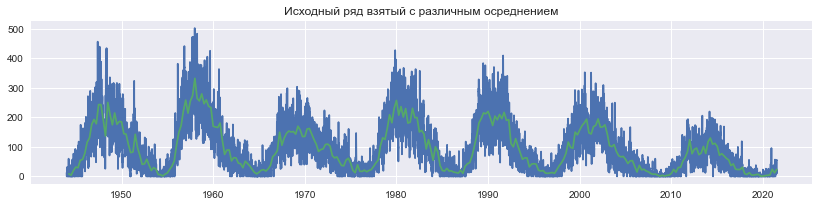

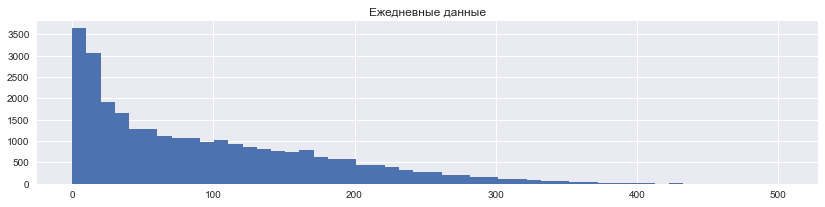

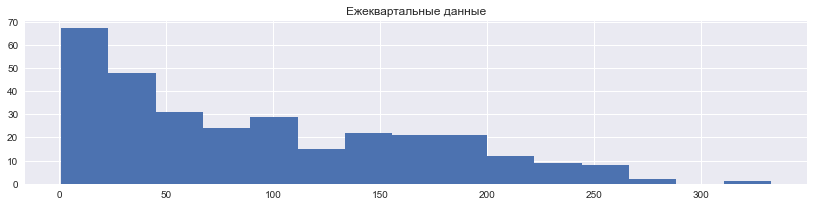

In [20]:
# Сформируем из исходных данных ежемесечную и ежеквартальную стстистику
ts = pd.Series(data=df.sunspots, index=df.index)
ts_quarter = ts.resample('Q').mean()
#Рассмотрим полученные данные
plt.plot(ts)
plt.plot(ts_quarter)
plt.title('Исходный ряд взятый с различным осреднением')
plt.show()
plt.hist(ts,bins=50)
plt.title('Ежедневные данные')
plt.show()
plt.hist(ts_quarter,bins=15)
plt.title('Ежеквартальные данные')
plt.show()

- Ряд имеет ярко выроженную периодичность
- Данные имеют логнорманое распределение
- Преобразуем данные к нормальному распределению при помощи метод Бокса-Кокса

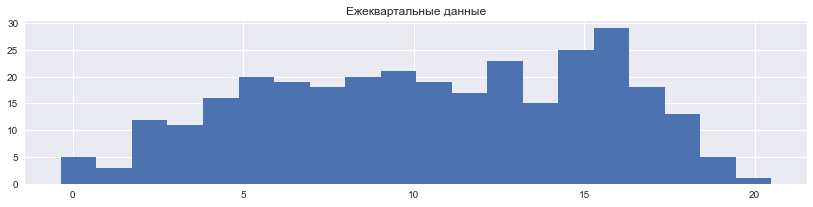

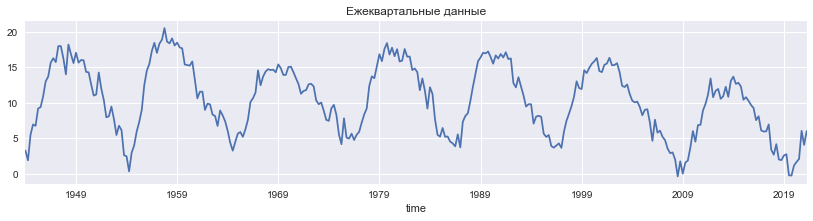

Лямбда (для ежеквартального ряда): 0.37017186909635286


In [21]:
ts_quart_bc = ts_quarter.copy
tmp,lmbda_quart = stats.boxcox(ts_quarter+10e-10)
ts_quart_bc = pd.Series(tmp,index=ts_quarter.index)
ts_quart_bc.hist(bins=20)
plt.title('Ежеквартальные данные')
plt.show()
ts_quart_bc.plot()
plt.title('Ежеквартальные данные')
plt.show()
print('Лямбда (для ежеквартального ряда): '+str(lmbda_quart))

### Анализ

#### Стационарность

In [22]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Проверим на станционарность наш ежеквартальный ряд. Для этого произведем двухсторонний анализ:
- Применим расширенный тест Дики-Фуллера (ADF). В нём H_0 - ряд нестационарен, H_a - ряд стационарен
- Применим тест Квятковский-Филлипс-Шмидт-Шин (KPSS). В нём H_0 - ряд стационарен, H_a - ряд нестационарен

In [23]:
adf_test(ts_quart_bc)

Results of Dickey-Fuller Test:
Test Statistic                -6.205805e+00
p-value                        5.661827e-08
#Lags Used                     8.000000e+00
Number of Observations Used    3.010000e+02
Critical Value (1%)           -3.452263e+00
Critical Value (5%)           -2.871191e+00
Critical Value (10%)          -2.571912e+00
dtype: float64


In [24]:
kpss_test(ts_quart_bc)

Results of KPSS Test:
Test Statistic            0.380011
p-value                   0.085771
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Взяв за основу уровень значимости 0.05 имеем:
- ADF тест утверждает, что наш ежеквартальный ряд явзяется стационарным (т.к. ADF.Н_0 отвергается)
- KPSS тест утверждает, что наш ежеквартальный ряд явзяется стационарным (т.к. KPSS.Н_0 не отвергается)

Таким образом оба теста утверждают, что ежеквартальный ряд является стационарным.

Проверим на станционарность так же ряд ежедневных остатков.

Так как рассматриваемые ряды являются стационарными значит можно определить порядок разности:
- d = 0

#### Автокорреляционный анализ

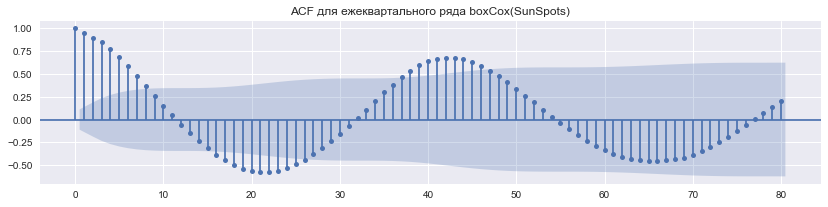

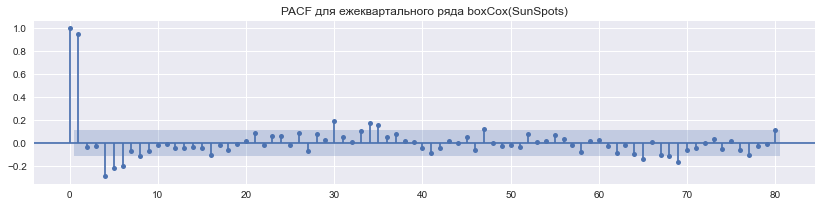

In [25]:
sm.graphics.tsa.plot_acf(ts_quart_bc,lags=80,title='ACF для ежеквартального ряда boxСox(SunSpots)')
plt.show()
sm.graphics.tsa.plot_pacf(ts_quart_bc,lags=80,title='PACF для ежеквартального ряда boxСox(SunSpots)')
plt.show()

Операясь на данные солнечной актиивности (https://en.wikipedia.org/wiki/Solar_cycle) можно установить, что период активности равен 11 годам. Однако, периодичность слегка плавающая и это приблизительная цифра, потому для уверенности взглянем на корелограмму. Из этого следует, что параметр количество временных шагов за один сезонный период (S) для наших рядов будет следующим:
- S_quart = [43,44]

Опрежделим параметры для ежеквартального ряда:
- Из диаграммы ACF определим параметры D, q, P:
- - порядок сезонных разниц D = 1 (у ряда стабильные сезонный ресунок по времени)
- - тренд скользящего среднего q = 17 (первый значимый лаг на ACF)
- - сезонный порядок авторегрессии P = 1 (значение на ACF при лаге = S положительное и P+Q≤2)
- Из диаграммы PACF определим параметры p, Q:
- - порядок авторегрессии тренда p = 5 (первый значимый лаг на PACF)
- - сезонный порядок скользящих средних Q = 0 (значение на PACF при лаге = S не является отрицательным и P+Q≤2)

### Подбор модели
В качестве модели для нашего ряда возьмем сезонную модель авторегрессии скользящих средних (SARIMA). Эта модель учитывает как тренд так и сезонность в данных. Ограничением данной модели является требование стационарности ряда, однако, как мы показали выше наш ряд является стационарным.

#### Подбор модели для ежеквартального ряда

##### Выбор шага периода

Проверим сначала какой из шагов больше подходит для нашей модели 43 или 44.

In [26]:
res_quart_bc_43 = sm.tsa.statespace.SARIMAX(ts_quart_bc, trend='n', order=(5,0,17), seasonal_order=(1,1,[],43)).fit()
print(res_quart_bc_43.summary())
del res_quart_bc_43

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  310
Model:             SARIMAX(5, 0, 17)x(1, 1, [], 43)   Log Likelihood                -482.943
Date:                              Mon, 27 Dec 2021   AIC                           1013.886
Time:                                      14:20:03   BIC                           1099.980
Sample:                                  03-31-1944   HQIC                          1048.469
                                       - 06-30-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      1.846      0.437      0.662      -2.812       4.425
ar.L2         -0.19

In [27]:
res_quart_bc_44 = sm.tsa.statespace.SARIMAX(ts_quart_bc, trend='n', order=(5,0,17), seasonal_order=(1,1,[],44)).fit()
print(res_quart_bc_44.summary())
del res_quart_bc_44

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  310
Model:             SARIMAX(5, 0, 17)x(1, 1, [], 44)   Log Likelihood                -476.533
Date:                              Mon, 27 Dec 2021   AIC                           1001.065
Time:                                      14:20:39   BIC                           1087.069
Sample:                                  03-31-1944   HQIC                          1035.617
                                       - 06-30-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0638      0.290      3.666      0.000       0.495       1.632
ar.L2         -0.66

Рассмотрим результаты и их интерпретацию:
- Качество модели:
- - Log Likelihood - логарифм коэфициента правдоподобия (чем больше тем лучше)
- - AIC - Информационный критерий Акаике (чем меньше тем лучше)
- - BIC - Байесовский информационный критерий (чем меньше тем лучше)
- - HQIC - Информационный критерий Ханнана-Куина (чем меньше тем лучше)
- Оценки остатков:
- - Ljung-Box (L1) (Q) - критерий Льюнг-Бокса, который тестирует остатки на авторорреляцию
- - Prob(Q) - значимость критерий Льюнг-Бокса
- - Heteroskedasticity (H) - тест на ниличие в остатках гетероскедастичности
- - Prob(H) (two-sided) - значимость теста на гетероскедастичность
- - Jarque-Bera (JB) - тест Харке-Бера, который проверяет остатки на нормальность
- - Prob(JB) - значимость теста Харке-Бера
- - Skew - коэффициент ассимметрии в тетсте Харке-Бера (у нормального распределения 0)
- - Kurtosis - коэффициент эксцесса втесте Харке-Бера (или мера остроты пика)

Проанализируем результаты:
- модели-44 имеет Log Likelihood больше чем модели-43
- модели-44 имеет меньший AIC чем модели-43:
- модели-44 имеет меньший BIC чем модели-43:
- модели-44 имеет меньший HQIC чем модели-43:
- остатки модели-44 более похожи на белый шум нежели у модели-43

Из всего вышеперечисленного следует, что шаг s_quart = 44 (так как он обеспечивает лучшее качество модели)

##### Оптимизация гиперпараметров

Чтобы удостоверится, что мы выбрали действительно лучшую модель, произведем поиск гиперпараметров моделе по сетке в небольшом деапазоне вокруг подобранных гиперпараметров.

In [28]:
gmodel_quart_bc = pm.auto_arima(
                                ts_quart_bc,
                                test='adf',
                                start_p=5, max_p=6,
                                start_q=17, max_q=18,
                                m=44,
                                start_P=1,
                                d=0, D=1,
                                seasonal=True, trace=True, stepwise=True,
                                error_action='ignore', suppress_warnings=True
                                )
print(gmodel_quart_bc.summary())
del gmodel_quart_bc

Performing stepwise search to minimize aic
 ARIMA(5,0,17)(1,1,1)[44] intercept   : AIC=inf, Time=47.27 sec
 ARIMA(0,0,0)(0,1,0)[44] intercept   : AIC=1372.402, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[44] intercept   : AIC=1006.735, Time=1.37 sec
 ARIMA(0,0,1)(0,1,1)[44] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[44]             : AIC=1377.805, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[44] intercept   : AIC=1078.322, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[44] intercept   : AIC=997.070, Time=3.80 sec
 ARIMA(1,0,0)(2,1,1)[44] intercept   : AIC=inf, Time=10.04 sec
 ARIMA(1,0,0)(1,1,1)[44] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,0)(2,1,0)[44] intercept   : AIC=1317.528, Time=2.51 sec
 ARIMA(2,0,0)(2,1,0)[44] intercept   : AIC=988.907, Time=4.32 sec
 ARIMA(2,0,0)(1,1,0)[44] intercept   : AIC=998.908, Time=1.64 sec
 ARIMA(2,0,0)(2,1,1)[44] intercept   : AIC=inf, Time=16.06 sec
 ARIMA(2,0,0)(1,1,1)[44] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(3,0,0)(2,1,0)[44] intercept   : AIC=983.6

Анализ результатов:

Сравним две модели res_quart_bc_44(далее м-1) и gmodel_quart_bc(далее м-2):
- Коеффициент правдападобия в м-1 выше чем в м-2
- Критерии AIC, BIC и HQIC для м-2 ниже чем для м-1
- Остатки у м-2 ближе к белому шуму чем у модели м-1

Не смотря на то что коэфициент правдоподобия для м-1 выше чем для м-2, модель м-2 считается лучшей (опираясь на критерии AIC, BIC и HQIC) т.к. имеет меньшее количество параметров (при том не значительно теряя в качестве). Кроме того остатки м-2 более похожи на белый шум, что так же говорит в её пользу.

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  310
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 44)   Log Likelihood                -483.878
Date:                             Mon, 27 Dec 2021   AIC                            981.756
Time:                                     14:27:52   BIC                           1006.841
Sample:                                 03-31-1944   HQIC                           991.834
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0924      0.212      0.437      0.662      -0.322       0.507
ar.L2          0.4803      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


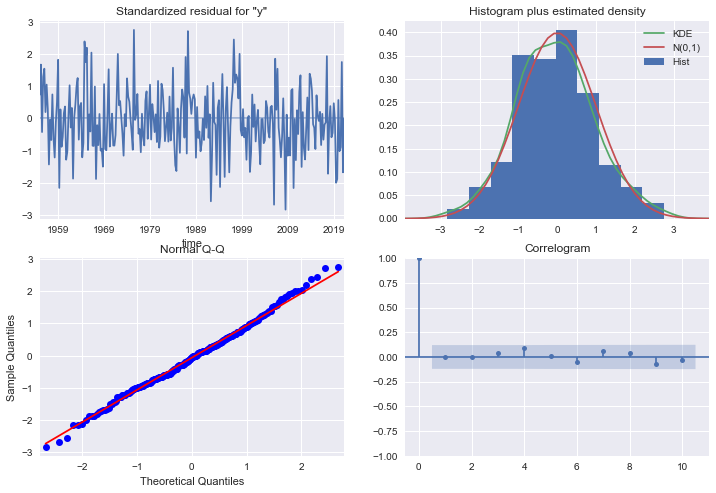

In [29]:
best_quart_bc = sm.tsa.statespace.SARIMAX(ts_quart_bc, trend='n', order=(3,0,1), seasonal_order=(2,1,[],44)).fit()
print(best_quart_bc.summary())
best_quart_bc.plot_diagnostics(figsize=([12,8]))
plt.show()

#### Работа с остатками

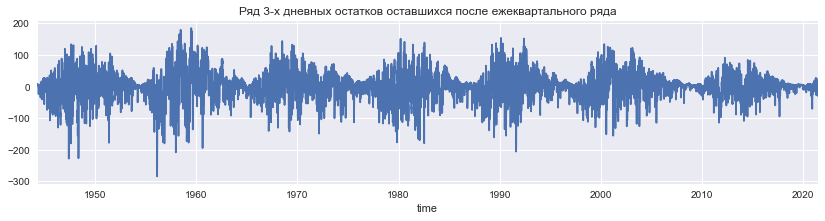

In [30]:
# Сформируем ряд остатков путем вычетания из исходного ежедневного ряда интерполированного к 1 дню ежеквартального ряда
tmp = pd.concat([ts_quarter[:45], invboxcox(best_quart_bc.fittedvalues[45:],lmbda_quart)])
tmp = tmp.resample('d').mean()
tmp.interpolate(method='linear', inplace=True)
err_dayly = (tmp-ts.astype(float)).resample('3d').mean()[30:]

# Нарисуем его
err_dayly.plot()
plt.title('Ряд 3-х дневных остатков оставшихся после ежеквартального ряда')
plt.show()

##### Стационарность

In [31]:
adf_test(err_dayly)

Results of Dickey-Fuller Test:
Test Statistic                -1.258202e+01
p-value                        1.901273e-23
#Lags Used                     3.300000e+01
Number of Observations Used    9.372000e+03
Critical Value (1%)           -3.431048e+00
Critical Value (5%)           -2.861848e+00
Critical Value (10%)          -2.566934e+00
dtype: float64


In [32]:
kpss_test(err_dayly)

Results of KPSS Test:
Test Statistic            0.076521
p-value                   0.100000
Lags Used                43.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Взяв за основу уровень значимости 0.05 имеем:
- ADF тест утверждает, что наш ежеквартальный ряд явзяется стационарным (т.к. ADF.Н_0 отвергается)
- KPSS тест утверждает, что наш ежеквартальный ряд явзяется стационарным (т.к. ADF.Н_0 не отвергается)

Таким образом оба теста утверждают, что ряд ежедневных остатков так же является стационарным.

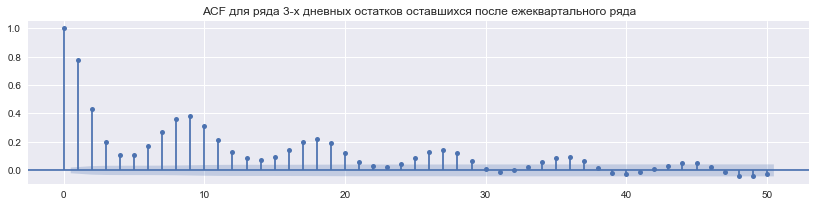

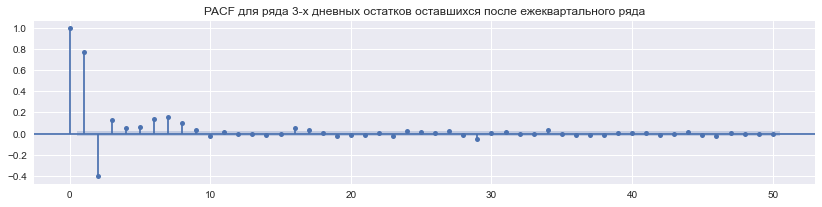

In [33]:
sm.graphics.tsa.plot_acf(err_dayly, lags=50,title='ACF для ряда 3-х дневных остатков оставшихся после ежеквартального ряда')
plt.show()
sm.graphics.tsa.plot_pacf(err_dayly, lags=50,title='PACF для ряда 3-х дневных остатков оставшихся после ежеквартального ряда')
plt.show()

Если приглядеться к графику ACF то можно заметить небольшой нисходящий тренд.
Для борьбы с этим эффектом продифференцируем ряд с шагом 1 и снова построим корелограмму.

Замечание:
- Несмотря на то, что наш предыдущий вывод (основанный на тестах ADF и KPSS) говорит о стационарности ряда остатков, корелограмма показывает, что в ряде есть некий малый тренд.
- Из этого следует, что не стоит всегда доверять численным критериям, для того чтобы окончательно убедиться в стационарности ряда необходимо строить и анализировать корелограмму.

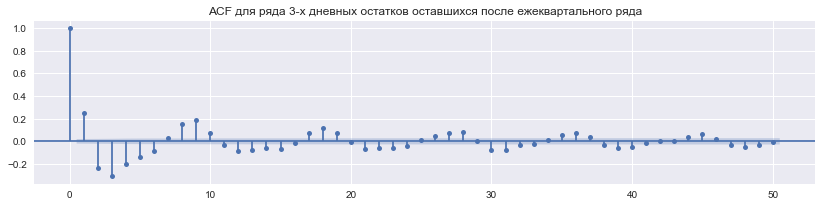

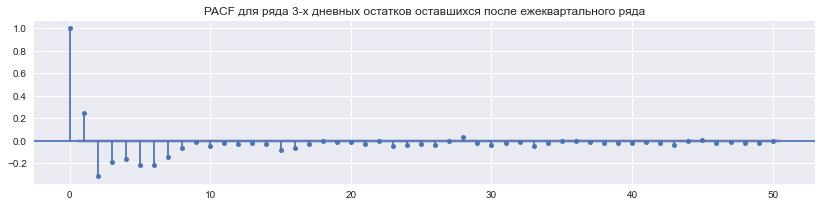

In [34]:
sm.graphics.tsa.plot_acf(err_dayly.diff(1)[1:], lags=50,title='ACF для ряда 3-х дневных остатков оставшихся после ежеквартального ряда')
plt.show()
sm.graphics.tsa.plot_pacf(err_dayly.diff(1)[1:], lags=50,title='PACF для ряда 3-х дневных остатков оставшихся после ежеквартального ряда')
plt.show()

Эффект пропал следовательно:
- Параметр порядока разности d = 1

Опрежделим параметры для ряда ежедневных остатков:
- Из диаграммы ACF определим параметры S, D, q, P:
- - количество временных шагов за один сезонный период S = 9 (легко заметить периодичность)
- - порядок сезонной разности D = 0 (у ряда невполне стабильная сезонность)
- - порядок скользящего среднего q = 2 (первый значимый лаг на ACF)
- - порядок сезонной авторегрессии P = 1 (значение на ACF при лаге = S является положительным и P+Q≤2)
- Из диаграммы PACF определим параметры p, Q:
- - порядок авторегрессии p = 3 (первый значимый лаг на PACF)
- - сезонный параметр скользящего среднего Q = 1 (значение на PACF при лаге = S отрицательное и P+Q≤2)

#### Подбор модели для ряда ежедневных остатков

##### Выбор шага периода

In [35]:
res_err_dayly = sm.tsa.statespace.SARIMAX(
    err_dayly, order=(2,1,2), seasonal_order=(1,0,1,9)).fit()
print(res_err_dayly.summary())
del res_err_dayly

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 9406
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 9)   Log Likelihood              -43610.743
Date:                             Mon, 27 Dec 2021   AIC                          87235.486
Time:                                     14:27:59   BIC                          87285.529
Sample:                                 03-31-1944   HQIC                         87252.477
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8865      0.017     51.005      0.000       0.852       0.921
ar.L2         -0.3324      

##### Оптимизация гиперпараметров

Чтобы удостоверится, что мы выбрали действительно лучшую модель, произведем поиск гиперпараметров моделе по сетке в небольшом деапазоне вокруг подобранных гиперпараметров.

In [36]:
gmodel_err_dayly = pm.auto_arima(
                                err_dayly,
                                test='adf',
                                start_p=2, max_p=3, d=1, start_q=2, max_q=3,
                                start_P=1, D=0, start_Q=1, m=9,
                                seasonal=True, trace=True, stepwise=True,
                                error_action='ignore', suppress_warnings=True
                                )
print(gmodel_err_dayly.summary())
del gmodel_err_dayly

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[9] intercept   : AIC=87237.485, Time=12.93 sec
 ARIMA(0,1,0)(0,0,0)[9] intercept   : AIC=90550.365, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[9] intercept   : AIC=89749.944, Time=2.08 sec
 ARIMA(0,1,1)(0,0,1)[9] intercept   : AIC=89427.000, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[9]             : AIC=90548.366, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[9] intercept   : AIC=87269.240, Time=7.88 sec
 ARIMA(2,1,2)(1,0,0)[9] intercept   : AIC=87254.950, Time=7.06 sec
 ARIMA(2,1,2)(2,0,1)[9] intercept   : AIC=87239.564, Time=26.47 sec
 ARIMA(2,1,2)(1,0,2)[9] intercept   : AIC=87239.457, Time=28.88 sec
 ARIMA(2,1,2)(0,0,0)[9] intercept   : AIC=87385.108, Time=3.55 sec
 ARIMA(2,1,2)(0,0,2)[9] intercept   : AIC=87239.966, Time=19.40 sec
 ARIMA(2,1,2)(2,0,0)[9] intercept   : AIC=87237.832, Time=19.15 sec
 ARIMA(2,1,2)(2,0,2)[9] intercept   : AIC=87241.371, Time=31.51 sec
 ARIMA(1,1,2)(1,0,1)[9] intercept   : AIC=inf, Time=13.57 sec
 ARIMA(2,1,1)(1,0,

Анализ результатов:

Сравним две модели res_err_dayly(далее м-1) и gmodel_err_dayly(далее м-2):
- Коеффициент правдападобия в м-2 выше чем в м-1
- Критерии AIC, BIC и HQIC для м-2 ниже чем для м-1

Отсюда следует что модель м-2 лучше

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 9406
Model:             SARIMAX(3, 1, 2)x(0, 0, 2, 9)   Log Likelihood              -43604.758
Date:                           Mon, 27 Dec 2021   AIC                          87225.516
Time:                                   14:36:43   BIC                          87282.708
Sample:                               03-31-1944   HQIC                         87244.934
                                    - 06-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5550      0.066     23.535      0.000       1.425       1.684
ar.L2         -1.0143      0.068    -14.971

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


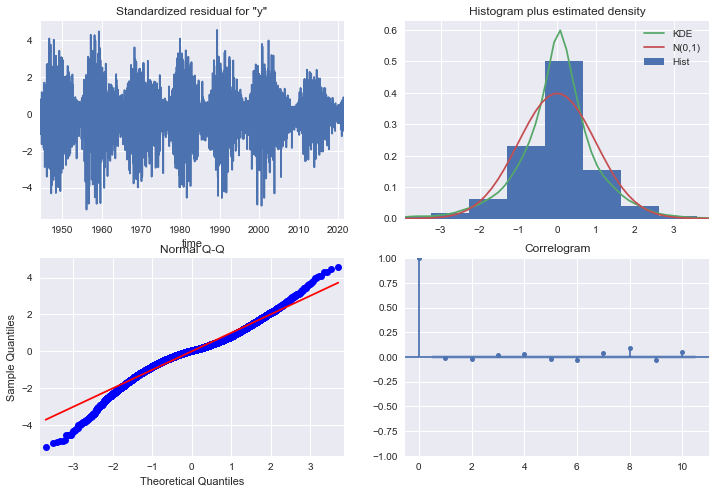

In [37]:
best_err_dayly = sm.tsa.statespace.SARIMAX(err_dayly, order=(3, 1, 2), seasonal_order=(0, 0, 2, 9)).fit()
print(best_err_dayly.summary())
best_err_dayly.plot_diagnostics(figsize=([12,8]))
plt.show()

Взглянем на остатки лучшей модели

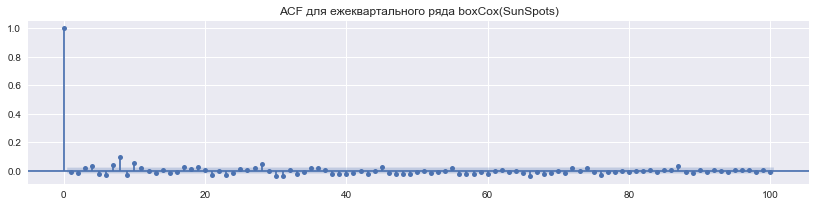

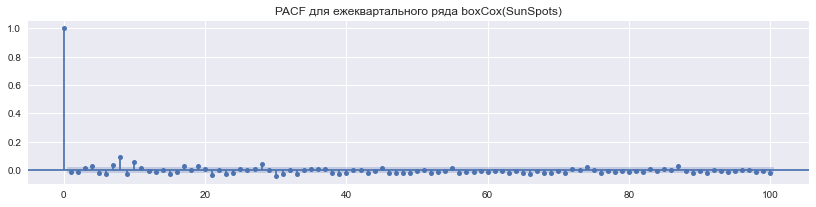

In [38]:
sm.graphics.tsa.plot_acf(best_err_dayly.resid,lags=100,title='ACF для ежеквартального ряда boxСox(SunSpots)')
plt.show()
sm.graphics.tsa.plot_pacf(best_err_dayly.resid,lags=100,title='PACF для ежеквартального ряда boxСox(SunSpots)')
plt.show()

Как можно видеть остатки слабо автокоррелированы и в целом их можно оставить в таком виде.

### Предсказание

In [39]:
# Функция поправки начальных и конечных значений предсказания
# Она нам необходима чтобы избежать ошибок при предсказании моделей best_quart_bc и best_err_dayly,
#  т.к. их временные шаги отличаются от 1 дня.
def fix_start_stop_point(strt,stp,ts):
    if strt<ts.index[-1]:
        tmp0 = (strt - ts.index).to_numpy().astype(np.int64)
        tmp0[tmp0<0] = 10**16
        strt1 = ts.index[np.argmin(tmp0)]
    else:
        strt1 = strt   
    if stp<ts.index[-1]:
        tmp0 = (ts.index - stp).to_numpy().astype(np.int64)
        tmp0[tmp0<0] = 10**16
        stp1 = ts.index[np.argmin(tmp0)]
    else:
        stp1 = stp        
    return strt1, stp1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


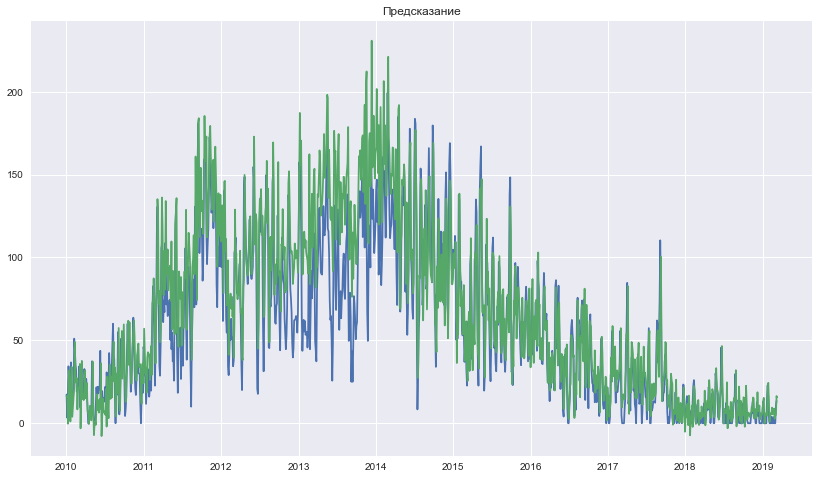

In [40]:
# Период предсказания
period = pd.DateOffset( years=9,months=2,days=7)
# Начала предсказания
strt = pd.Timestamp('2010-01-01T12')
# Конец предсказания
stp = strt+period #pd.Timestamp('2023-01-01T12')

# Коррекция начала и конца предсказания
strt1, stp1 =fix_start_stop_point(strt,stp,ts_quart_bc)
strt2, stp2 = fix_start_stop_point(strt1,stp1,err_dayly)
# Предсказание ежеквартального ряда
forecast_quart_bc = best_quart_bc.predict(
    start = strt1,
    end= stp1,
    dynamic= True)
forecast_quart = invboxcox(forecast_quart_bc,lmbda_quart).resample('D').mean()
forecast_quart.interpolate(method='linear', inplace=True)
# Предсказание ряда 3-х дневных остатков
forecast_err = best_err_dayly.predict(
    start = strt2,
    end= stp2,
    dynamic= False)
forecast_err = forecast_err.resample('D').mean()
forecast_err.interpolate(method='linear', inplace=True)

# Изобразим исходный ряд
plt.figure(figsize=[14, 8])
plt.plot(ts[(ts.index>=strt)&(ts.index<=stp)].resample('3d').mean())
# Нарисуем на предсказанный ряд
plt.plot(
            forecast_quart[(forecast_quart.index>=strt)&(forecast_quart.index<=stp)] -
            forecast_err[(forecast_err.index>=strt)&(forecast_err.index<=stp)]
        )
plt.title('Предсказание')
plt.show()